# Intro
In this notebook I process the data to provide with training and validation dataset for eSRGAN fine-tuning. 

**Data description**
The initial data is captured by Carl Zeiss Z1 fluorescent microscope in *Brain Stem Cell laboratory* of MIPT by Anna Ivanova and represent the propidium iodid-labeled cells. Such method is used for brain structure labelling along with Nissl structures. The data represent the half of the brain of healthy adult mice. Data is collected as stack of 572 2D-slices, each is an 8bit tif image with sizes 9000 x 7680 pixels.

**Processes**
eSRGAN was trained on dataset to restore 128x128 images, downscaled to 32x32 with bicubic interpolation. The same principle is taken here. 2D slices were uploaded and cropped randomely to images with size from 64x64 to 256x256. After that GT (ground truth) images were acquired by resizing this images to 128x128 with Nearest Neighbours interpolation, while LR (low res) images were generated by the same manner - rescaling to 32x32. 

Totally there were ~15000 images generated with original GT-crop with sizes from 128 to 256 and ~5000 images with original GT-crop with sizes from 64 to 128 pixels.

**Additional visualizations**

## Imports

In [1]:
import sys
import os

#!pip install --user --upgrade opencv-python
import cv2
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

#!pip install --user --upgrade imutils
import imutils

import torch

from IPython.display import clear_output

# Original data
Read and visualize 2D slice

In [2]:
data_folder = './data_Z1/tiffs/'
files = os.listdir(data_folder)

def sort_slice_idx(name):
    return int(name.split(' ')[-1].split('.')[0])

files.sort(key = sort_slice_idx)
print(len(files))
print(files[:5])

572
['Sample3_4x5_561nm_PI-stitched frame 1 plane 1.tif', 'Sample3_4x5_561nm_PI-stitched frame 1 plane 2.tif', 'Sample3_4x5_561nm_PI-stitched frame 1 plane 3.tif', 'Sample3_4x5_561nm_PI-stitched frame 1 plane 4.tif', 'Sample3_4x5_561nm_PI-stitched frame 1 plane 5.tif']


In [3]:
img_slice = cv2.imread(os.path.join(data_folder, files[327]), -1)
img_slice.size

221184000

In [4]:
img_slice.shape

(9600, 7680, 3)

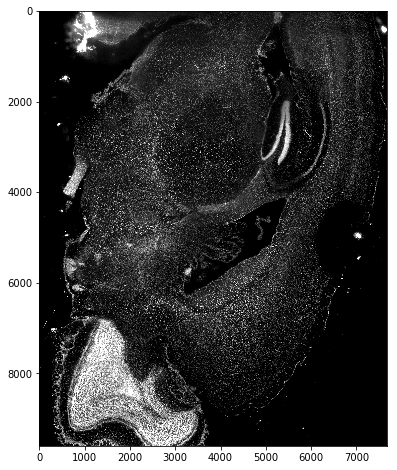

In [5]:
plt.figure(figsize=(16,8))
plt.imshow(img_slice[:,:,0], cmap='gray')
plt.show()

# Examples of distortion and data generation

In [6]:
from scipy.signal import convolve2d

In [10]:
## From mmsr.codes.data.utils

import math

# matlab 'imresize' function, now only support 'bicubic'
def cubic(x):
    absx = torch.abs(x)
    absx2 = absx**2
    absx3 = absx**3
    return (1.5 * absx3 - 2.5 * absx2 + 1) * (
        (absx <= 1).type_as(absx)) + (-0.5 * absx3 + 2.5 * absx2 - 4 * absx + 2) * ((
            (absx > 1) * (absx <= 2)).type_as(absx))


def calculate_weights_indices(in_length, out_length, scale, kernel, kernel_width, antialiasing):
    if (scale < 1) and (antialiasing):
        # Use a modified kernel to simultaneously interpolate and antialias- larger kernel width
        kernel_width = kernel_width / scale

    # Output-space coordinates
    x = torch.linspace(1, out_length, out_length)

    # Input-space coordinates. Calculate the inverse mapping such that 0.5
    # in output space maps to 0.5 in input space, and 0.5+scale in output
    # space maps to 1.5 in input space.
    u = x / scale + 0.5 * (1 - 1 / scale)

    # What is the left-most pixel that can be involved in the computation?
    left = torch.floor(u - kernel_width / 2)

    # What is the maximum number of pixels that can be involved in the
    # computation?  Note: it's OK to use an extra pixel here; if the
    # corresponding weights are all zero, it will be eliminated at the end
    # of this function.
    P = math.ceil(kernel_width) + 2

    # The indices of the input pixels involved in computing the k-th output
    # pixel are in row k of the indices matrix.
    indices = left.view(out_length, 1).expand(out_length, P) + torch.linspace(0, P - 1, P).view(
        1, P).expand(out_length, P)

    # The weights used to compute the k-th output pixel are in row k of the
    # weights matrix.
    distance_to_center = u.view(out_length, 1).expand(out_length, P) - indices
    # apply cubic kernel
    if (scale < 1) and (antialiasing):
        weights = scale * cubic(distance_to_center * scale)
    else:
        weights = cubic(distance_to_center)
    # Normalize the weights matrix so that each row sums to 1.
    weights_sum = torch.sum(weights, 1).view(out_length, 1)
    weights = weights / weights_sum.expand(out_length, P)

    # If a column in weights is all zero, get rid of it. only consider the first and last column.
    weights_zero_tmp = torch.sum((weights == 0), 0)
    if not math.isclose(weights_zero_tmp[0], 0, rel_tol=1e-6):
        indices = indices.narrow(1, 1, P - 2)
        weights = weights.narrow(1, 1, P - 2)
    if not math.isclose(weights_zero_tmp[-1], 0, rel_tol=1e-6):
        indices = indices.narrow(1, 0, P - 2)
        weights = weights.narrow(1, 0, P - 2)
    weights = weights.contiguous()
    indices = indices.contiguous()
    sym_len_s = -indices.min() + 1
    sym_len_e = indices.max() - in_length
    indices = indices + sym_len_s - 1
    return weights, indices, int(sym_len_s), int(sym_len_e)

def imresize_np(img, scale, antialiasing=True):
    # Now the scale should be the same for H and W
    # input: img: Numpy, HWC BGR [0,1]
    # output: HWC BGR [0,1] w/o round
    img = torch.from_numpy(img)

    in_H, in_W, in_C = img.size()
    _, out_H, out_W = in_C, math.ceil(in_H * scale), math.ceil(in_W * scale)
    kernel_width = 4
    kernel = 'cubic'

    # Return the desired dimension order for performing the resize.  The
    # strategy is to perform the resize first along the dimension with the
    # smallest scale factor.
    # Now we do not support this.

    # get weights and indices
    weights_H, indices_H, sym_len_Hs, sym_len_He = calculate_weights_indices(
        in_H, out_H, scale, kernel, kernel_width, antialiasing)
    weights_W, indices_W, sym_len_Ws, sym_len_We = calculate_weights_indices(
        in_W, out_W, scale, kernel, kernel_width, antialiasing)
    # process H dimension
    # symmetric copying
    img_aug = torch.FloatTensor(in_H + sym_len_Hs + sym_len_He, in_W, in_C)
    img_aug.narrow(0, sym_len_Hs, in_H).copy_(img)

    sym_patch = img[:sym_len_Hs, :, :]
    inv_idx = torch.arange(sym_patch.size(0) - 1, -1, -1).long()
    sym_patch_inv = sym_patch.index_select(0, inv_idx)
    img_aug.narrow(0, 0, sym_len_Hs).copy_(sym_patch_inv)

    sym_patch = img[-sym_len_He:, :, :]
    inv_idx = torch.arange(sym_patch.size(0) - 1, -1, -1).long()
    sym_patch_inv = sym_patch.index_select(0, inv_idx)
    img_aug.narrow(0, sym_len_Hs + in_H, sym_len_He).copy_(sym_patch_inv)

    out_1 = torch.FloatTensor(out_H, in_W, in_C)
    kernel_width = weights_H.size(1)
    for i in range(out_H):
        idx = int(indices_H[i][0])
        out_1[i, :, 0] = img_aug[idx:idx + kernel_width, :, 0].transpose(0, 1).mv(weights_H[i])
        out_1[i, :, 1] = img_aug[idx:idx + kernel_width, :, 1].transpose(0, 1).mv(weights_H[i])
        out_1[i, :, 2] = img_aug[idx:idx + kernel_width, :, 2].transpose(0, 1).mv(weights_H[i])

    # process W dimension
    # symmetric copying
    out_1_aug = torch.FloatTensor(out_H, in_W + sym_len_Ws + sym_len_We, in_C)
    out_1_aug.narrow(1, sym_len_Ws, in_W).copy_(out_1)

    sym_patch = out_1[:, :sym_len_Ws, :]
    inv_idx = torch.arange(sym_patch.size(1) - 1, -1, -1).long()
    sym_patch_inv = sym_patch.index_select(1, inv_idx)
    out_1_aug.narrow(1, 0, sym_len_Ws).copy_(sym_patch_inv)

    sym_patch = out_1[:, -sym_len_We:, :]
    inv_idx = torch.arange(sym_patch.size(1) - 1, -1, -1).long()
    sym_patch_inv = sym_patch.index_select(1, inv_idx)
    out_1_aug.narrow(1, sym_len_Ws + in_W, sym_len_We).copy_(sym_patch_inv)

    out_2 = torch.FloatTensor(out_H, out_W, in_C)
    kernel_width = weights_W.size(1)
    for i in range(out_W):
        idx = int(indices_W[i][0])
        out_2[:, i, 0] = out_1_aug[:, idx:idx + kernel_width, 0].mv(weights_W[i])
        out_2[:, i, 1] = out_1_aug[:, idx:idx + kernel_width, 1].mv(weights_W[i])
        out_2[:, i, 2] = out_1_aug[:, idx:idx + kernel_width, 2].mv(weights_W[i])

    return out_2.numpy()

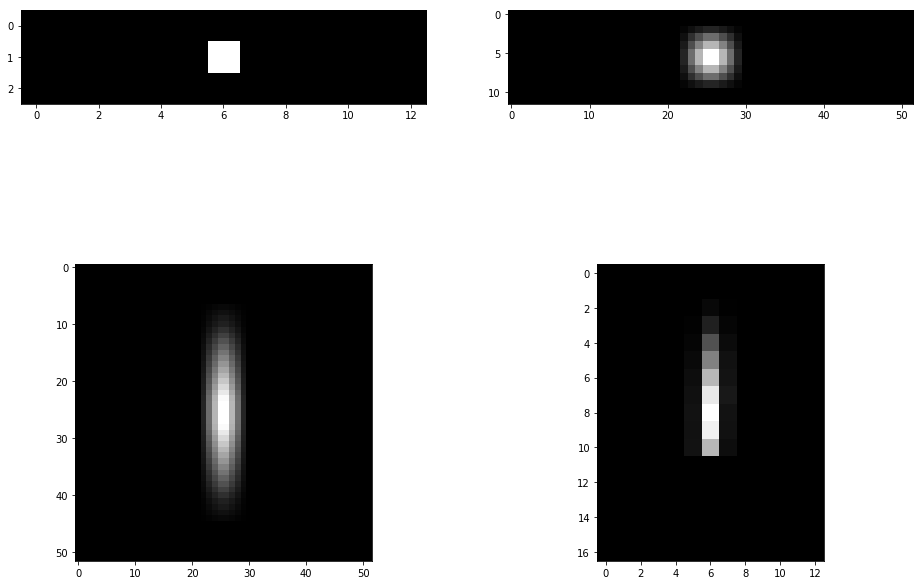

(17, 13)


In [70]:
plt.figure(figsize=(16,12))

plt.subplot(221)
size = (3,13)
kernel = np.zeros(size)
kernel[int(size[0]//2), int(size[1]//2)] = 1
kernel = kernel / np.sum(kernel)
plt.imshow(kernel, cmap='gray')

plt.subplot(222)
kernel = cv2.resize(kernel, (kernel.shape[1]*4, kernel.shape[0]*4), cv2.INTER_CUBIC )
plt.imshow(kernel, cmap='gray')

plt.subplot(223)
kernel = cv2.resize(kernel, (kernel.shape[1]*1,int(kernel.shape[0]*(size[1]/size[0]))), cv2.INTER_CUBIC )
plt.imshow(kernel, cmap='gray')

plt.subplot(224)
kernel = cv2.resize(kernel, (kernel.shape[1]//4, kernel.shape[0]//3), cv2.INTER_CUBIC )
step  = kernel.shape[0]//2
mask = np.ones_like(kernel)
mask[step+3:,:] = 0
kernel = kernel*mask
kernel = kernel / np.sum(kernel)

angle = np.random.randint(-30,30)
rows, cols = kernel.shape
M_inverse = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
kernel = cv2.warpAffine(kernel, M_inverse, (cols, rows))

plt.imshow(kernel, cmap='gray')
plt.show()

print(kernel.shape)

In [69]:
np.random.randint(-30,30)

20

In [61]:
kernel

### Test if their 'cubic' interpolation gives another results than cv2.INTER_CUBIC
No

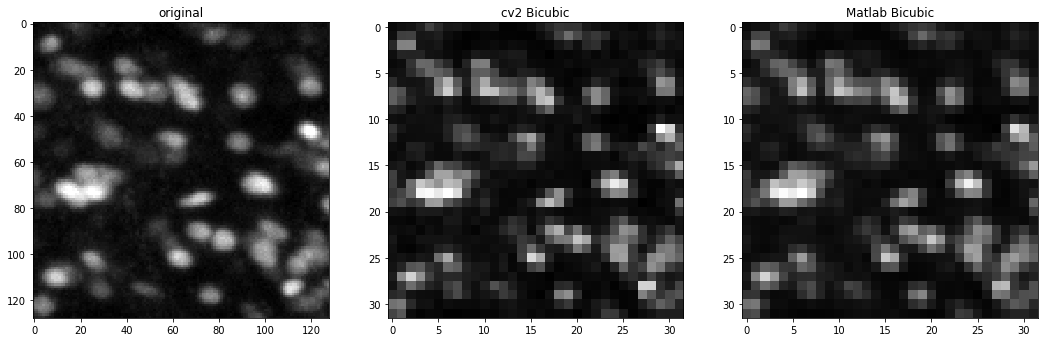

In [11]:
plt.figure(figsize=(18,8))

img_size = 128
start_x = 3000
start_y = 1500
resize = 4

part = img_slice[start_x:start_x+img_size, start_y:start_y+img_size, 0]


plt.subplot(131)
plt.imshow(part.astype(np.float64)/255, cmap='gray')
part_resized = imutils.resize(part.astype(np.float64)/255, width=int(part.shape[1]//resize), inter=cv2.INTER_CUBIC )
plt.title('original')

plt.subplot(132)
plt.imshow(part_resized, cmap='gray')
plt.title('cv2 Bicubic')

plt.subplot(133)
part = cv2.cvtColor(part, cv2.COLOR_GRAY2BGR )
part = part.astype(np.float64)/255
part_resized = imresize_np(part, 1/resize)
part_resized = cv2.cvtColor((part_resized*255).astype(np.uint8), cv2.COLOR_RGB2GRAY ).astype(np.float64)/255

#part_resized = imutils.resize(part, width=int(part.shape[1]//(resize/2)), inter=cv2.INTER_CUBIC )
#part_resized_motion = cv2.filter2D(part_resized, -1, kernel)
#part_resized_motion = imutils.resize(part_resized_motion, width=int(part_resized_motion.shape[1]//(resize/2)), inter=cv2.INTER_CUBIC )
#plt.imshow(part_resized_motion, cmap='gray')
plt.imshow(part_resized, cmap='gray')
plt.title('Matlab Bicubic')

plt.show()

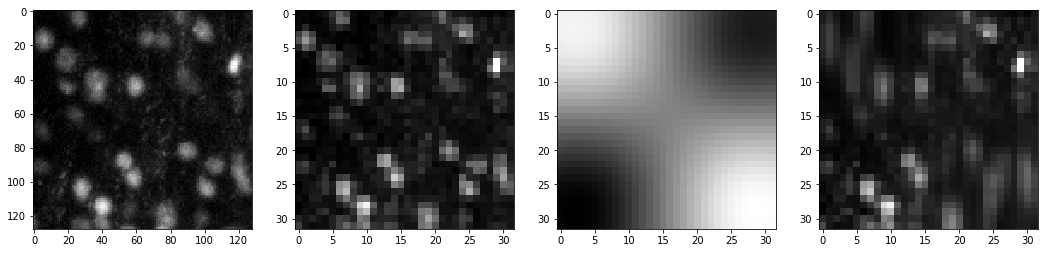

In [71]:
plt.figure(figsize=(18,8))

img_size = 128
start_x = 2000
start_y = 1500
resize = 4

part = img_slice[start_x:start_x+img_size, start_y:start_y+img_size, 0]
part_resized = imutils.resize(part, width=int(part.shape[1]//resize), inter=cv2.INTER_CUBIC )

part = imutils.resize(part, width=128, inter=cv2.INTER_NEAREST )

plt.subplot(141)
plt.imshow(part, cmap='gray')
part_resized = imutils.resize(part_resized, width=int(part.shape[1]//resize), inter=cv2.INTER_CUBIC )

plt.subplot(142)
plt.imshow(part_resized, cmap='gray')

#part_resized = imutils.resize(part, width=int(part.shape[1]//(resize/2)), inter=cv2.INTER_CUBIC )
#part_resized_motion = cv2.filter2D(part_resized, -1, kernel)
#part_resized_motion = imutils.resize(part_resized_motion, width=int(part_resized_motion.shape[1]//(resize/2)), inter=cv2.INTER_CUBIC )

part_resized = imutils.resize(part, width=int(part.shape[1]//(resize)), inter=cv2.INTER_CUBIC )
part_resized_motion = cv2.filter2D(part_resized, -1, kernel)
#part_resized_motion = imutils.resize(part_resized_motion, width=int(part_resized_motion.shape[1]//(resize)), inter=cv2.INTER_CUBIC )

plt.subplot(143)
detalization = 2
mask = np.random.random(detalization*detalization)
mask = mask.reshape((detalization,detalization))
mask = imutils.resize(mask, width=32, inter=cv2.INTER_CUBIC )
plt.imshow(mask, cmap='gray')

part_resized_motion = part_resized_motion*mask + part_resized*(1-mask)

plt.subplot(144)
plt.imshow(part_resized_motion, cmap='gray')
plt.show()


# Check cross-slice connection

In [197]:
img_slice_0 = cv2.imread(os.path.join(data_folder, files[0]), -1)
img_slice_1 = cv2.imread(os.path.join(data_folder, files[1]), -1)
img_slice_2 = cv2.imread(os.path.join(data_folder, files[2]), -1)

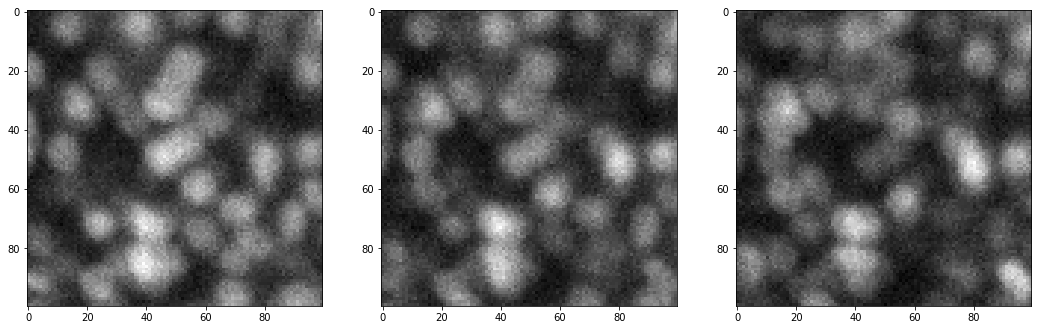

In [198]:
plt.figure(figsize=(18,8))

img_size = 100
start_x = 2000
start_y = 3000
resize = 4

plt.subplot(131)
part_0 = img_slice_0[start_x:start_x+img_size, start_y:start_y+img_size, 0]
plt.imshow(part_0, cmap='gray')

plt.subplot(132)
part_1 = img_slice_1[start_x:start_x+img_size, start_y:start_y+img_size, 0]
plt.imshow(part_1, cmap='gray')

plt.subplot(133)
part_2 = img_slice_2[start_x:start_x+img_size, start_y:start_y+img_size, 0]
plt.imshow(part_2, cmap='gray')
plt.show()

### See the slice over Z

In [126]:
crop_parts = []
img_size = 512
start_x = 0
start_y = 3000

for i in range(0,100):
    img_tmp = cv2.imread(os.path.join(data_folder, files[i]), -1)
    crop_parts.append( img_tmp[start_x:start_x+img_size, start_y:start_y+img_size, 0] )

crop_parts = np.array(crop_parts)
crop_parts.shape

(100, 512, 512)

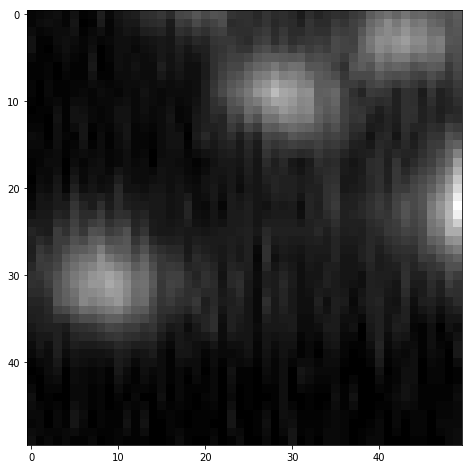

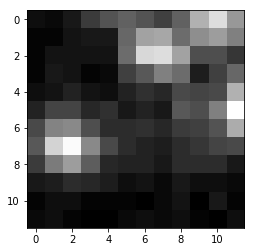

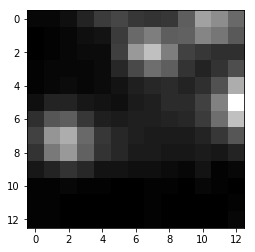

In [246]:
plt.figure(figsize=(16,8))
proj = crop_parts[:,:,220]
proj = cv2.resize(proj, (proj.shape[1], int(proj.shape[0]*2.7)), cv2.INTER_CUBIC )

cell = proj[100:150,300:350]

plt.imshow(cell, cmap='gray')
plt.show()

cell = cv2.resize(cell, (int(cell.shape[1]//4), int(cell.shape[0]//4)), cv2.INTER_CUBIC )
plt.imshow(cell, cmap='gray')
plt.show()

img_test = cv2.cvtColor(proj[100:150,300:350], cv2.COLOR_GRAY2BGR )
img_test = img_test.astype(np.float64)/255

img_new = imresize_np(img_test, 1/4)
img_new = cv2.cvtColor((img_new*255).astype(np.uint8), cv2.COLOR_BGR2GRAY ).astype(np.float64)/255

plt.imshow(img_new, cmap='gray')
plt.show()

<hr>

## Prepare images for training

In [73]:
def generate_train_val_idx(list_of_tif_files, train_num, test_num):
    # Z-idx
    total_num_slices = len(list_of_tif_files)
    test_z = np.random.choice(np.arange(0,total_num_slices,1), int(total_num_slices/3), replace=False)
    train_z = np.array([idx for idx in range(total_num_slices) if idx not in test_z])
    
    train_z_idx = np.random.choice(train_z, train_num)
    test_z_idx = np.random.choice(test_z, test_num)
    
    # X, Y - coordinate
    train_start_x = np.random.randint(500,6000, train_num)
    train_start_y = np.random.randint(2000,6000, train_num)
    
    test_start_x = np.random.randint(500,6000, test_num)
    test_start_y = np.random.randint(2000,6000, test_num)
    
    # Image Sizes
    #img_sizes = np.random.randint(128,256, train_num + test_num)
    img_sizes = np.random.randint(64, 128, train_num + test_num)
    train_img_sizes = img_sizes[:train_num]
    test_img_sizes = img_sizes[train_num:]
    
    train_idx = {}
    for z, x, y, size in zip(train_z_idx, train_start_x, train_start_y, train_img_sizes):
        if z in train_idx.keys():
            train_idx[z].append((x, y, size))
        else:
            train_idx[z] = [(x, y, size)]
      
    test_idx = {}
    for z, x, y, size in zip(test_z_idx, test_start_x, test_start_y, test_img_sizes):
        if z in test_idx.keys():
            test_idx[z].append( (x, y, size) )
        else:
            test_idx[z] = [(x, y, size)]
    
    return train_idx, test_idx

In [293]:
generate_train_val_idx(files, 2,2)

({438: [(890, 2480, 118)], 174: [(4275, 3410, 91)]},
 {465: [(1474, 4634, 114)], 123: [(698, 2719, 80)]})

In [294]:
input_size = 32
output_size = 128

train_num = 5000 #20000
test_num = 300 #1000

data_folder = './data_Z1/tiffs/'
    
train_folder_gt = './mmsr/datasets/train_data_Z1_GT/' #train_data_Z1_GT_additional180120
train_folder_lr = './mmsr/datasets/train_data_Z1_LR/'

val_folder_gt = './mmsr/datasets/val_data_Z1_GT/'
val_folder_lr = './mmsr/datasets/val_data_Z1_LR/'

In [295]:
# Think before launch
!!!!!!delete

train, valid = generate_train_val_idx(files, train_num, test_num)
unique_id = 1

for i_z, z_idx in enumerate(train.keys()):
    pieces = train[z_idx]
    tmp_slice = cv2.imread(os.path.join(data_folder, files[z_idx]), -1)
    
    for i_xy, shape in enumerate(pieces):
        (x,y,size) = shape
        part = tmp_slice[x:x+size, y:y+size, 0]
        part = np.transpose([part,part,part], (1,2,0))
        part = imutils.resize(part, width=output_size, inter=cv2.INTER_NEAREST )
        
        part_resized = imutils.resize(part, width=input_size, inter=cv2.INTER_CUBIC )
        
        # Images are loaded by idx in sorted list
        cv2.imwrite(os.path.join(train_folder_gt, 'train_Z1_'+'{:06d}'.format(unique_id)+'.png'), part)
        cv2.imwrite(os.path.join(train_folder_lr, 'train_Z1_'+'{:06d}'.format(unique_id)+'.png'), part_resized)
        
        unique_id +=1
        
    clear_output()
    print(i_z, 'done out of', len(train.keys()))  

print('train - finished')
unique_id = 1


for i_z, z_idx in enumerate(valid.keys()):
    pieces = valid[z_idx]
    tmp_slice = cv2.imread(os.path.join(data_folder, files[z_idx]), -1)
    
    for i_xy, shape in enumerate(pieces):
        (x,y,size) = shape
        part = tmp_slice[x:x+size, y:y+size, 0]
        part = np.transpose([part,part,part], (1,2,0))
        part = imutils.resize(part, width=output_size, inter=cv2.INTER_NEAREST )
        part_resized = imutils.resize(part, width=input_size, inter=cv2.INTER_CUBIC )
        
        # Images are loaded by idx in sorted list
        cv2.imwrite(os.path.join(val_folder_gt, 'valid_Z1_'+'{:06d}'.format(unique_id)+'.png'), part)
        cv2.imwrite(os.path.join(val_folder_lr, 'valid_Z1_'+'{:06d}'.format(unique_id)+'.png'), part_resized)
        
        unique_id +=1
        
    clear_output()
    print(i_z, 'done out of', len(valid.keys()))  

print('valid - finished')

154 done out of 155
valid - finished


In [296]:
test_gt = sorted(os.listdir(val_folder_gt))
test_lr = sorted(os.listdir(val_folder_lr))

test_gt[:5], test_lr[:5]

(['.ipynb_checkpoints',
  'val_Z10000.png',
  'valid_Z1_000000.png',
  'valid_Z1_000001.png',
  'valid_Z1_000002.png'],
 ['.ipynb_checkpoints',
  'val_Z10000.png',
  'valid_Z1_000000.png',
  'valid_Z1_000001.png',
  'valid_Z1_000002.png'])

### Examples

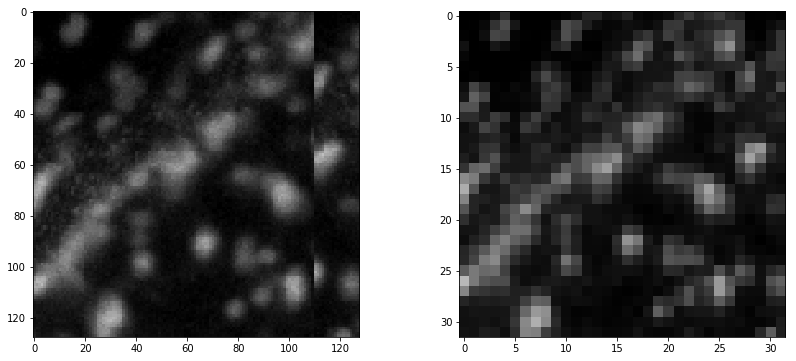

In [289]:
for i in range(3):
    img_size = np.random.randint(128,256)
    start_x = np.random.randint(500,6000)
    start_y = np.random.randint(2000,6000)
    resize = 4
    
    part = img_slice[start_x:start_x+img_size, start_y:start_y+img_size, 0]
    part = np.transpose([part,part,part], (1,2,0))
    part = imutils.resize(part, width=128, inter=cv2.INTER_NEAREST )
    
    part_resized = imutils.resize(part, width=int(part.shape[1]//resize), inter=cv2.INTER_CUBIC )
    
    
    #cv2.imwrite(os.path.join(train_folder_gt, 'train_Z1'+'{:04d}'.format(i)+'.png'), part)
    #cv2.imwrite(os.path.join(train_folder_lr, 'train_Z1'+'{:04d}'.format(i)+'.png'), part_resized)
    
    clear_output(3)
    
    plt.figure(figsize=(14,6))
    plt.subplot(121)
    plt.imshow(part, cmap='gray')
    plt.subplot(122)
    plt.imshow(part_resized, cmap='gray')
    plt.show()

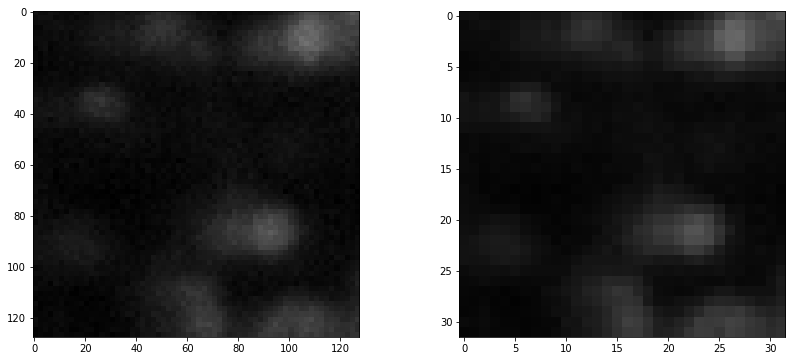

In [291]:
for i in range(1):
    img_size = 64#np.random.randint(128,256)
    start_x = np.random.randint(500,6000)
    start_y = np.random.randint(2000,6000)
    resize = 4
    
    part = img_slice[start_x:start_x+img_size, start_y:start_y+img_size, 0]
    part = np.transpose([part,part,part], (1,2,0))
    part = imutils.resize(part, width=128, inter=cv2.INTER_NEAREST )
    
    part_resized = imutils.resize(part, width=int(part.shape[1]//resize), inter=cv2.INTER_CUBIC )
    
    cv2.imwrite(os.path.join(val_folder_gt, 'val_Z1'+'{:04d}'.format(i)+'.png'), part)
    cv2.imwrite(os.path.join(val_folder_lr, 'val_Z1'+'{:04d}'.format(i)+'.png'), part_resized)
    
    clear_output(3)
    
    plt.figure(figsize=(14,6))
    plt.subplot(121)
    plt.imshow(part, cmap='gray')
    plt.subplot(122)
    plt.imshow(part_resized, cmap='gray')
    plt.show()

<hr>

## Additional train dataset
this data represents additional augmentation added by motion blur to image
> 18.01.2020

In [167]:
input_size = 32
output_size = 128

train_num = 3000 #20000
test_num = 300 #1000

data_folder = './data_Z1/tiffs/'
    
train_folder_gt = './mmsr/datasets/train_data_Z1_GT_additional180120/' #train_data_Z1_GT_additional180120
train_folder_lr = './mmsr/datasets/train_data_Z1_LR_additional180120/'

In [147]:
def generate_gt(tmp_slice, shape):
    (x,y,size) = shape
    part = tmp_slice[x:x+size, y:y+size, 0]
    return part

def generate_mb_kernel():
    size = (3,np.random.choice([9,13]))
    kernel = np.zeros(size)
    kernel[int(size[0]//2), int(size[1]//2)] = 1
    kernel = kernel / np.sum(kernel)
    
    kernel = cv2.resize(kernel, (kernel.shape[1]*4, kernel.shape[0]*4), cv2.INTER_CUBIC )
    kernel = cv2.resize(kernel, (kernel.shape[1]*1,int(kernel.shape[0]*(size[1]/size[0]))), cv2.INTER_CUBIC )
    
    kernel = cv2.resize(kernel, (kernel.shape[1]//4, kernel.shape[0]//3), cv2.INTER_CUBIC )
    step  = kernel.shape[0]//2 + int(0.15*kernel.shape[0])
    
    mask = np.ones_like(kernel)
    mask[step,:] = mask[step,:]*0.5
    mask[step+1:,:] = 0
    kernel = kernel*mask
    kernel = kernel / np.sum(kernel)

    angle = np.random.randint(-10,10)
    rows, cols = kernel.shape
    M_inverse = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    kernel = cv2.warpAffine(kernel, M_inverse, (cols, rows))
    return kernel
    
def generate_lr(part, kernel):
    resize = 4
    detalization = 2
    
    part_resized = imutils.resize(part, width=int(part.shape[1]//resize), inter=cv2.INTER_CUBIC )
    part_resized_motion = cv2.filter2D(part_resized, -1, kernel)

    mask = np.random.random(detalization*detalization)
    mask = mask.reshape((detalization,detalization))
    mask = imutils.resize(mask, width=part_resized.shape[1], inter=cv2.INTER_CUBIC )

    part_resized_motion = part_resized_motion*mask + part_resized*(1-mask)
    return part_resized_motion

In [165]:
train, valid = generate_train_val_idx(files, 1, 1)
z_idx =list( train.keys() )[0]

pieces = train[z_idx]
tmp_slice = cv2.imread(os.path.join(data_folder, files[z_idx]), -1)

shape = pieces[0]

(128, 128)


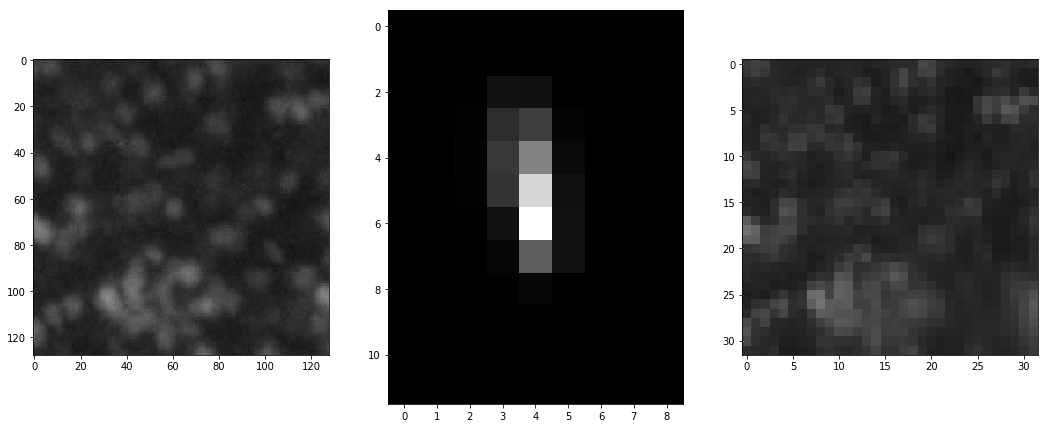

In [166]:
train, valid = generate_train_val_idx(files, 1, 1)
z_idx =list( train.keys() )[0]
shape = train[z_idx][0]

part = generate_gt(tmp_slice, shape)
part = cv2.resize(part, (128,128), cv2.INTER_NEAREST )
print(part.shape)
kernel = generate_mb_kernel()
part_resized = generate_lr(part, kernel)

part = np.transpose([part,part,part], (1,2,0))
part = np.uint8(part)

part_resized = np.transpose([part_resized,part_resized,part_resized], (1,2,0))
part_resized = np.uint8(part_resized)

plt.figure(figsize=(18,8))
plt.subplot(131)
plt.imshow(part, cmap='gray')
plt.subplot(132)
plt.imshow(kernel, cmap='gray')
plt.subplot(133)
plt.imshow(part_resized, cmap='gray')
plt.show()

In [168]:
train, valid = generate_train_val_idx(files, train_num, test_num)
unique_id = 1

for i_z, z_idx in enumerate(train.keys()):
    pieces = train[z_idx]
    tmp_slice = cv2.imread(os.path.join(data_folder, files[z_idx]), -1)
    
    for i_xy, shape in enumerate(pieces):
        part = generate_gt(tmp_slice, shape)
        part = cv2.resize(part, (128,128), cv2.INTER_NEAREST )
        kernel = generate_mb_kernel()
        part_resized = generate_lr(part, kernel)

        part = np.transpose([part,part,part], (1,2,0))
        part = np.uint8(part)

        part_resized = np.transpose([part_resized,part_resized,part_resized], (1,2,0))
        part_resized = np.uint8(part_resized)
        
        # Images are loaded by idx in sorted list
        cv2.imwrite(os.path.join(train_folder_gt, 'train_Z1_'+'{:06d}'.format(unique_id)+'.png'), part)
        cv2.imwrite(os.path.join(train_folder_lr, 'train_Z1_'+'{:06d}'.format(unique_id)+'.png'), part_resized)
        
        unique_id +=1
        
    clear_output()
    print(i_z, 'done out of', len(train.keys()))  

print('train - finished')

381 done out of 382
train - finished


In [161]:
part.shape, part.dtype, part_resized.shape, part_resized.dtype

((128, 128, 3), dtype('uint8'), (19, 19, 3), dtype('uint8'))